<a href="https://colab.research.google.com/github/coolx1/DL-with-Logic/blob/main/CNNAdd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3>Problem: Computing the sum of a sequence of MNIST digits<h3>
<p>
Example:
<p>


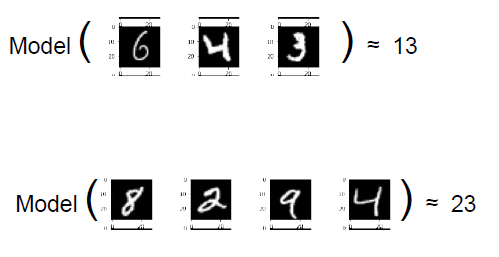

In this set of experiments I create models and test their in-distribution and out-of-distribution(longer sequences of numbers) generalization capabilities. This work is directly inspired by the papers DeepProbLog: Neural Probabilistic Logic Programming([https://arxiv.org/abs/1805.10872](https://arxiv.org/abs/1805.10872)) and Neural Arithmetic and Logic Units([https://arxiv.org/abs/1808.00508](https://arxiv.org/abs/1808.00508)). The Models I'm going to try are as follows

1.   CNN provided with the logic of addition
2.   CNN with LSTM
3.   CNN + custom RNN Models

I create custom RNN models with some intuition so as to enable the model to extrapolate to longer sequences.



In [1]:
import torch
import torchvision

In [ ]:
# Loading the MNIST dataset and converting the datatype of elements to pytorch tensors
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_trainset = torchvision.datasets.MNIST("drive/MyDrive/MNIST", transform = transform)
mnist_testset = torchvision.datasets.MNIST("drive/MyDrive/MNIST", train=False, transform = transform)

In [ ]:
import random
# This function creates a dataset of a sequence of digit input and sum output from the loaded MNIST dataset.
def create_dataset(mnist_dataset, num_samples_list, num_terms_list, is_train=1, random_seed = 111):
  """
  Inputs:
  num_terms_list is a list of sequence lengths of samples for creating the dataset. Ex: [5, 6]
  
  num_samples_list is a list of number of samples corresponding to each sequence length. Ex: [4000, 2000]
  
  if is_train is true then the unction considers it as creating the training set and the mnist images in the 
  datasets of different sequence lengths do not overlap with each other. Else, if it is the test set, overlap 
  of images between datasets of different sequence lengths is allowed

  Outputs:

  return_list: List of datasets of sequences of images corresponding to each sequence provided in the input
  return_nums_list: List of datasets of sequences of numbers corresponding to those of the return_list
  return_y_list: List of list of outputs corresponding to above datasets
  """
  random.seed(random_seed)
  def separate_dataset(mnist_dataset):
    return_dict = {i:[] for i in range(10)}
    for element in mnist_dataset:
      return_dict[element[1]].append(element[0])
    return return_dict

  dataset_dict = separate_dataset(mnist_dataset)
  if(is_train):
    iterator = [0 for i in range(10)]
  return_list = []
  return_nums_list = []
  return_y_list = []
  for (num_terms, num_samples) in zip(num_terms_list, num_samples_list):
    if(not(is_train)):
      iterator = [0 for i in range(10)]
    already_sampled = []
    sample_list = []
    sample_y_list = []
    for _ in range(num_samples):
      sample_elements = random.choices([i for i in range(10)], k=num_terms)
      while(sample_elements in already_sampled):
        sample_elements = random.choices([i for i in range(10)], k=num_terms)
      already_sampled.append(sample_elements)
      sample_y_list.append(sum(sample_elements))
      
      sample = []
      for ele in sample_elements:
        sample.append(dataset_dict[ele][iterator[ele]])
        iterator[ele] = iterator[ele] + 1
      sample_list.append(torch.stack(sample))
    return_y_list.append(torch.tensor(sample_y_list))
    return_nums_list.append(torch.tensor(already_sampled))
    return_list.append(torch.stack(sample_list))
  return return_list, return_nums_list, return_y_list


I'm creating training and validation data sequences of lengths 5 and 6

Training samples corresponding to each sequence length = 4000

Validation samples corresponding to each sequence length = 800

In [ ]:
train_dataset_X, train_dataset_nums, train_dataset_y = create_dataset(mnist_trainset, [4000, 4000], [5, 6])
print(train_dataset_X[0].shape, train_dataset_X[1].shape)
print(train_dataset_nums[0].shape, train_dataset_nums[1].shape)
print(train_dataset_y[0].shape, train_dataset_y[1].shape)

torch.save(train_dataset_X[0], "drive/MyDrive/CNNAdd/data/train_dataset_X_5.pt")
torch.save(train_dataset_nums[0], "drive/MyDrive/CNNAdd/data/train_dataset_nums_5.pt")
torch.save(train_dataset_y[0], "drive/MyDrive/CNNAdd/data/train_dataset_y_5.pt")
torch.save(train_dataset_X[1], "drive/MyDrive/CNNAdd/data/train_dataset_X_6.pt")
torch.save(train_dataset_nums[1], "drive/MyDrive/CNNAdd/data/train_dataset_nums_6.pt")
torch.save(train_dataset_y[1], "drive/MyDrive/CNNAdd/data/train_dataset_y_6.pt")

test_dataset_X, test_dataset_nums, test_dataset_y = create_dataset(mnist_testset, [800, 800], [5, 6], is_train = 0, random_seed = 112)
print(test_dataset_X[0].shape, test_dataset_X[1].shape)
print(test_dataset_nums[0].shape, test_dataset_nums[1].shape)
print(test_dataset_y[0].shape, test_dataset_y[1].shape)

torch.save(test_dataset_X[0], "drive/MyDrive/CNNAdd/data/test_dataset_X_5.pt")
torch.save(test_dataset_nums[0], "drive/MyDrive/CNNAdd/data/test_dataset_nums_5.pt")
torch.save(test_dataset_y[0], "drive/MyDrive/CNNAdd/data/test_dataset_y_5.pt")
torch.save(test_dataset_X[1], "drive/MyDrive/CNNAdd/data/test_dataset_X_6.pt")
torch.save(test_dataset_nums[1], "drive/MyDrive/CNNAdd/data/test_dataset_nums_6.pt")
torch.save(test_dataset_y[1], "drive/MyDrive/CNNAdd/data/test_dataset_y_6.pt")

Here I create testsets to test extrapolation to longer sequences. I create datasets corresponding to sequence lengths 7, 8, 20.

In [ ]:
test_dataset_X, test_dataset_nums, test_dataset_y = create_dataset(mnist_testset, [800, 800, 400], [7, 8, 20], is_train=0, random_seed=113)
print(test_dataset_X[0].shape, test_dataset_X[1].shape, test_dataset_X[2].shape)
print(test_dataset_nums[0].shape, test_dataset_nums[1].shape, test_dataset_nums[2].shape)
print(test_dataset_y[0].shape, test_dataset_y[1].shape, test_dataset_y[2].shape)
torch.save(test_dataset_X[0], "drive/MyDrive/CNNAdd/data/test_dataset_X_7.pt")
torch.save(test_dataset_nums[0], "drive/MyDrive/CNNAdd/data/test_dataset_nums_7.pt")
torch.save(test_dataset_y[0], "drive/MyDrive/CNNAdd/data/test_dataset_y_7.pt")
torch.save(test_dataset_X[1], "drive/MyDrive/CNNAdd/data/test_dataset_X_8.pt")
torch.save(test_dataset_nums[1], "drive/MyDrive/CNNAdd/data/test_dataset_nums_8.pt")
torch.save(test_dataset_y[1], "drive/MyDrive/CNNAdd/data/test_dataset_y_8.pt")
torch.save(test_dataset_X[2], "drive/MyDrive/CNNAdd/data/test_dataset_X_20.pt")
torch.save(test_dataset_nums[2], "drive/MyDrive/CNNAdd/data/test_dataset_nums_20.pt")
torch.save(test_dataset_y[2], "drive/MyDrive/CNNAdd/data/test_dataset_y_20.pt")

In [2]:
# Data loading from drive
train_dataset_X_5 = torch.load("drive/MyDrive/CNNAdd/data/train_dataset_X_5.pt")
train_dataset_nums_5 = torch.load("drive/MyDrive/CNNAdd/data/train_dataset_nums_5.pt")
train_dataset_y_5 = torch.load("drive/MyDrive/CNNAdd/data/train_dataset_y_5.pt")
train_dataset_X_6 = torch.load("drive/MyDrive/CNNAdd/data/train_dataset_X_6.pt")
train_dataset_nums_6 = torch.load("drive/MyDrive/CNNAdd/data/train_dataset_nums_6.pt")
train_dataset_y_6 = torch.load("drive/MyDrive/CNNAdd/data/train_dataset_y_6.pt")

test_dataset_X_5 = torch.load("drive/MyDrive/CNNAdd/data/test_dataset_X_5.pt")
test_dataset_nums_5 = torch.load("drive/MyDrive/CNNAdd/data/test_dataset_nums_5.pt")
test_dataset_y_5 = torch.load("drive/MyDrive/CNNAdd/data/test_dataset_y_5.pt")
test_dataset_X_6 = torch.load("drive/MyDrive/CNNAdd/data/test_dataset_X_6.pt")
test_dataset_nums_6 = torch.load("drive/MyDrive/CNNAdd/data/test_dataset_nums_6.pt")
test_dataset_y_6 = torch.load("drive/MyDrive/CNNAdd/data/test_dataset_y_6.pt")

In [3]:
"""
Dataset class which also normalizes the MNIST images
"""
from torch.utils.data import Dataset, DataLoader
class CNNAddDataset(Dataset):
  def __init__(self, dataset_X, dataset_nums, dataset_y):
    self.dataset_X = dataset_X
    self.dataset_nums = dataset_nums
    self.dataset_y = dataset_y
    self.normalize_fn = torchvision.transforms.Normalize((0.1307,), (0.3081, ))
  
  def __len__(self):
    return len(self.dataset_y)

  def __getitem__(self, idx):
    sample = {"X": self.normalize_fn(self.dataset_X[idx]), "nums": self.dataset_nums[idx].float(), "y": self.dataset_y[idx].float()}
    return sample

In [4]:
"""
Creating train and test dataset objects for sequences of length 5 and 6
"""
dataset_train_5 = CNNAddDataset(train_dataset_X_5, train_dataset_nums_5, train_dataset_y_5)
dataset_test_5 = CNNAddDataset(test_dataset_X_5, test_dataset_nums_5, test_dataset_y_5)
dataset_train_6 = CNNAddDataset(train_dataset_X_6, train_dataset_nums_6, train_dataset_y_6)
dataset_test_6 = CNNAddDataset(test_dataset_X_6, test_dataset_nums_6, test_dataset_y_6)

In [5]:
# Loading the extrapolation test sets
test_dataset_X_7 = torch.load("drive/MyDrive/CNNAdd/data/test_dataset_X_7.pt")
test_dataset_nums_7 = torch.load("drive/MyDrive/CNNAdd/data/test_dataset_nums_7.pt")
test_dataset_y_7 = torch.load("drive/MyDrive/CNNAdd/data/test_dataset_y_7.pt")

test_dataset_X_8 = torch.load("drive/MyDrive/CNNAdd/data/test_dataset_X_8.pt")
test_dataset_nums_8 = torch.load("drive/MyDrive/CNNAdd/data/test_dataset_nums_8.pt")
test_dataset_y_8 = torch.load("drive/MyDrive/CNNAdd/data/test_dataset_y_8.pt")

test_dataset_X_20 = torch.load("drive/MyDrive/CNNAdd/data/test_dataset_X_20.pt")
test_dataset_nums_20 = torch.load("drive/MyDrive/CNNAdd/data/test_dataset_nums_20.pt")
test_dataset_y_20 = torch.load("drive/MyDrive/CNNAdd/data/test_dataset_y_20.pt")

dataset_test_7 = CNNAddDataset(test_dataset_X_7, test_dataset_nums_7, test_dataset_y_7)
dataset_test_8 = CNNAddDataset(test_dataset_X_8, test_dataset_nums_8, test_dataset_y_8)
dataset_test_20 = CNNAddDataset(test_dataset_X_20, test_dataset_nums_20, test_dataset_y_20)

BATCH_SIZE_TEST = 32
dataloader_test_7 = DataLoader(dataset_test_7, batch_size = BATCH_SIZE_TEST, num_workers = 2)
dataloader_test_8 = DataLoader(dataset_test_8, batch_size = BATCH_SIZE_TEST, num_workers = 2)
dataloader_test_20 = DataLoader(dataset_test_20, batch_size = BATCH_SIZE_TEST, num_workers = 2)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from torch import nn
import torch.nn.functional as F

<h2> Model1: ConvNet with addition logic provided<h2>

In this model, the convnet effectively only needs to learn to recognize the mnist images as the addition is taken care of by the logic. Model Diagram:

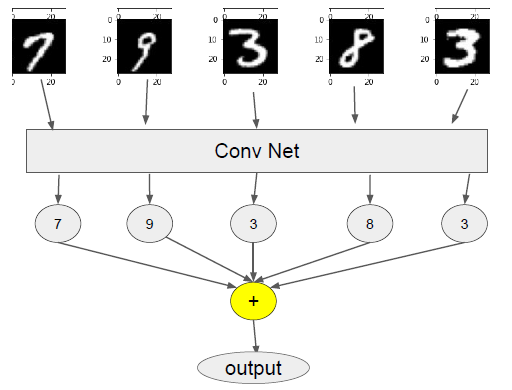

In [ ]:
"""
Conv Net with the logic of addition provided
"""
class ConvNetWithAdd(nn.Module):

  def __init__(self):
    super(ConvNetWithAdd, self).__init__()
    self.conv1 = nn.Conv2d(1,32,3,1)
    self.conv2 = nn.Conv2d(32,64,3,1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 1)

  def forward(self, x):
    x_shape = x.shape
    x = torch.reshape(x, (x_shape[0]*x_shape[1], x_shape[2], x_shape[3], x_shape[4]))
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = torch.reshape(x, (x_shape[0], x_shape[1]))
    return torch.sum(x, 1) # Addition of CNN outputs

This is the function to train the various models I create. This function trains the models simultaneously on both sequences of lengths 5 and 6. Plots the loss curves and Mean Absolute Error curves for both training and validation sets 

In [7]:
"""
function for training the various models I create.
"""
def train_model(model_input = "X"):
  #Lists for plotting graphs
  step = 0
  train_step_list = []
  val_step_list = []
  train_loss_5_list = []
  val_loss_5_list = []
  train_mae_5_list = []
  val_mae_5_list = []
  train_loss_6_list = []
  val_loss_6_list = []
  train_mae_6_list = []
  val_mae_6_list = []
  train_total_loss_list = []
  val_total_loss_list = []
  MIN_VAL_TOTAL_LOSS = 1e10

  for epoch in range(NUM_EPOCHS):
    print('Training:', file = out_file)
    print("Epoch: ", epoch, file = out_file)
    model.train()
    for i, (batch1, batch2) in enumerate(zip(dataloader_train_5, dataloader_train_6)):
      X_5 = batch1[model_input].cuda(device= device); X_6 = batch2[model_input].cuda(device = device)
      y_5 = batch1["y"].cuda(device = device); y_6 = batch2["y"].cuda(device = device)
      X_5_out = model(X_5); X_6_out = model(X_6)
      loss_5 = mse_loss(X_5_out, y_5); loss_6 = mse_loss(X_6_out, y_6)
      total_loss = (loss_5 + loss_6)/2.0
      if(i%TRAIN_LOSS_RECORD_STEPS == 0):
        train_step_list.append(step)
        train_loss_5_list.append(loss_5.item())
        train_loss_6_list.append(loss_6.item())
        train_total_loss_list.append(total_loss.item())
        print("Train Loss 5: ", loss_5.item(), file = out_file)
        print("Train Loss 6: ", loss_6.item(), file = out_file)
        print("Train Total Loss: ", total_loss.item(), file = out_file)

        train_5_mae = mean_absolute_error(X_5_out, y_5); train_6_mae = mean_absolute_error(X_6_out, y_6)
        train_mae_5_list.append(train_5_mae.item()); train_mae_6_list.append(train_6_mae.item())
        print("Train MAE 5:", train_5_mae.item(), file = out_file)
        print("Train MAE 6:", train_6_mae.item(), file = out_file)
      total_loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      step+=1
  
    print("Model Evaluation:", file = out_file)
    val_loss5_sum = 0; val_loss6_sum = 0
    val_total_loss_sum = 0
    val_mae5_sum = 0; val_mae6_sum = 0
    num_batches = len(dataloader_test_5)
    model.eval()
    for i, (batch1, batch2) in enumerate(zip(dataloader_test_5, dataloader_test_6)):
      X_5 = batch1[model_input].cuda(device= device); X_6 = batch2[model_input].cuda(device = device)
      y_5 = batch1["y"].cuda(device = device); y_6 = batch2["y"].cuda(device = device)
      X_5_out = model(X_5); X_6_out = model(X_6)
      loss_5 = mse_loss(X_5_out, y_5); loss_6 = mse_loss(X_6_out, y_6)
      total_loss = (loss_5 + loss_6)/2.0
      val_5_mae = mean_absolute_error(X_5_out, y_5); val_6_mae = mean_absolute_error(X_6_out, y_6)
    
      val_loss5_sum += loss_5.item(); val_loss6_sum += loss_6.item()
      val_total_loss_sum += total_loss.item()
      val_mae5_sum += val_5_mae.item(); val_mae6_sum += val_6_mae.item()

    current_val_total_loss = val_total_loss_sum/num_batches
    current_val_loss5 = val_loss5_sum/num_batches
    current_val_loss6 = val_loss6_sum/num_batches
    current_val_mae5 = val_mae5_sum/num_batches
    current_val_mae6 = val_mae6_sum/num_batches
    print("Validation loss 5 at epoch: ", epoch, " : ", current_val_loss5, file = out_file)
    print("Validation loss 6 at epoch: ", epoch, " : ", current_val_loss6, file = out_file)
    print("Validation total loss at epoch: ", epoch, " : ", current_val_total_loss, file = out_file)
    print("Validation mae 5 at epoch: ", epoch, " : ", current_val_mae5, file = out_file)
    print("Validation mae 6 at epoch: ", epoch, " : ", current_val_mae6, file = out_file)

    if(current_val_total_loss < MIN_VAL_TOTAL_LOSS):
      print("Current val total loss < min val total loss. Saving model..", file = out_file)
      torch.save(model.state_dict(), model_save_folder+best_model_name)
      print("Model Saved!", file = out_file)
      MIN_VAL_TOTAL_LOSS = current_val_total_loss
  
    val_step_list.append(step)
    val_loss_5_list.append(current_val_loss5); val_loss_6_list.append(current_val_loss6)
    val_total_loss_list.append(current_val_total_loss)
    val_mae_5_list.append(current_val_mae5); val_mae_6_list.append(current_val_mae6)
  out_file.close()

  # Plotting graphs
  import matplotlib.pyplot as plt

  def plot_graph(train_step_list, train_loss_list, val_step_list, val_loss_list, train_loss_label, val_loss_label, save_path):
    plt.plot(train_step_list, train_loss_list, color = "blue", label = train_loss_label)
    plt.plot(val_step_list, val_loss_list, color = "red", label = val_loss_label)
    plt.legend()
    plt.savefig(save_path)
    plt.close()

  plot_graph(train_step_list, train_loss_5_list, val_step_list, val_loss_5_list, "train loss 5", "val loss 5", graph_save_folder+loss_5_graph_name)
  plot_graph(train_step_list, train_loss_6_list, val_step_list, val_loss_6_list, "train loss 6", "val loss 6", graph_save_folder+loss_6_graph_name)
  plot_graph(train_step_list, train_total_loss_list, val_step_list, val_total_loss_list, "train total loss", "val total loss", graph_save_folder+total_loss_graph_name)
  plot_graph(train_step_list, train_mae_5_list, val_step_list, val_mae_5_list, "train mae 5", "val mae 5", graph_save_folder+mae_5_graph_name)
  plot_graph(train_step_list, train_mae_6_list, val_step_list, val_mae_6_list, "train mae 6", "val mae6", graph_save_folder+mae_6_graph_name)


In [ ]:
"""
Hyperparameters to train the CNN with Add Logic Model
BATCH SIZE = 32
NUMBER OF EPOCHS = 70
LEARNING RATE = 1e-3
optimizer = Adam
Loss Function = Mean squared error
"""
BATCH_SIZE = 32
NUM_EPOCHS = 70
LEARNING_RATE = 1e-3
TRAIN_LOSS_RECORD_STEPS  = 25
SHUFFLE = True
NUM_WORKERS = 2
model_save_folder = "drive/MyDrive/CNNAdd/saved_models/"
graph_save_folder = "drive/MyDrive/CNNAdd/graphs/"
best_model_name = "CNNAddBest.bin"
total_loss_graph_name = "total_loss.png"
loss_5_graph_name = "loss_5.png"
loss_6_graph_name = "loss_6.png"
mae_5_graph_name = "mae_5.png"
mae_6_graph_name = "mae_6.png"
out_file = open("drive/MyDrive/CNNAdd/terminal_output/CNNTraining.txt", "w")
model = ConvNetWithAdd()
device = torch.device("cuda")
model.to(device= device)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
mse_loss = nn.MSELoss(reduction="mean")
mean_absolute_error = nn.L1Loss(reduction = "mean")

print("PARAMETERS:\n LEARNING RATE: ", LEARNING_RATE, "\nBATCH SIZE: ", BATCH_SIZE, "\nEPOCHS: ",NUM_EPOCHS,"\nTRAIN LOSS RECORD STEPS",TRAIN_LOSS_RECORD_STEPS, file = out_file)

dataloader_train_5 = DataLoader(dataset_train_5, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)
dataloader_test_5 = DataLoader(dataset_test_5, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)
dataloader_train_6 = DataLoader(dataset_train_6, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)
dataloader_test_6 = DataLoader(dataset_test_6, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)

train_model()

<h2>Model2<h2>

CNN + LSTM model. The CNN outputs of images are fed sequentially to the LSTM Model. The LSTM model has to learn to add the numbers. Model Diagram

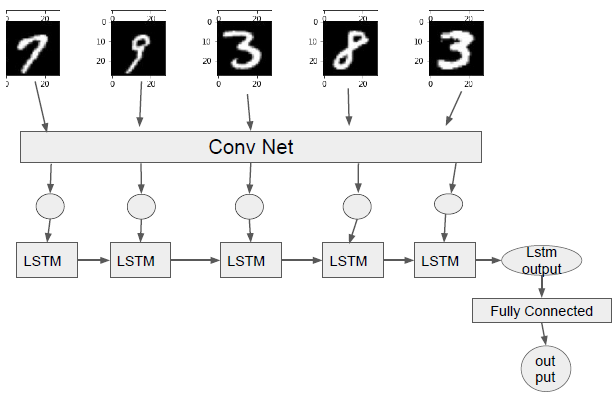

In [9]:
"""
Code for CNN + LSTM model. The CNN outputs of images are fed sequentially to the LSTM Model. The LSTM model has to learn to add the numbers. 
"""
class CNNLSTMMain(nn.Module):

  def __init__(self, input_size, lstm_hidden_size, device, num_lstm_layers = 1):
    super(CNNLSTMMain, self).__init__()
    self.conv1 = nn.Conv2d(1,32,3,1)
    self.conv2 = nn.Conv2d(32,64,3,1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 1)
    self.lstm_hidden_size = lstm_hidden_size
    self.lstm_layer = nn.LSTM(input_size, lstm_hidden_size, num_lstm_layers, batch_first = True)
    self.lstm_fc = nn.Linear(self.lstm_hidden_size, 1)
    self.device = device

  def forward(self, x):
    x_shape = x.shape
    x = torch.reshape(x, (x_shape[0]*x_shape[1], x_shape[2], x_shape[3], x_shape[4]))
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = torch.reshape(x, (x_shape[0], x_shape[1], 1))
    batch_size = x_shape[0]
    hidden_state = torch.randn(1, batch_size, self.lstm_hidden_size).cuda(device = self.device)
    cell_state = torch.randn(1, batch_size, self.lstm_hidden_size).cuda(device = self.device)
    all_out, (final_hidden_state, final_cell_state) = self.lstm_layer(x, (hidden_state, cell_state))
    final_hidden_state = final_hidden_state.view(-1, self.lstm_hidden_size) 
    out = F.relu(final_hidden_state)
    out = self.lstm_fc(out)
    out = F.relu(out)
    return out[:, 0]


In [10]:
# Code to train CNN+pytorch LSTM model
"""
Hyperparameters to train the CNN + pytorch LSTM Model
BATCH SIZE = 32
NUMBER OF EPOCHS = 300
LEARNING RATE = 1e-3
Hidden State Size of LSTM = 10 
optimizer = Adam
Loss Function = Mean squared error
"""

BATCH_SIZE = 32
NUM_EPOCHS = 300
LEARNING_RATE = 1e-3
TRAIN_LOSS_RECORD_STEPS  = 25
SHUFFLE = True
NUM_WORKERS = 2
device = torch.device("cuda")
model_save_folder = "drive/MyDrive/CNNAdd/saved_models/"
graph_save_folder = "drive/MyDrive/CNNAdd/graphs/"
input_size = 1
hidden_size =  10

best_model_name = "CNNLSTMBest.bin"
total_loss_graph_name = "cnnlstm_total_loss.png"
loss_5_graph_name = "cnnlstm_loss_5.png"
loss_6_graph_name = "cnnlstm_loss_6.png"
mae_5_graph_name = "cnnlstm_mae_5.png"
mae_6_graph_name = "cnnlstm_mae_6.png"
out_file = open("drive/MyDrive/CNNAdd/terminal_output/CNNLSTMTraining.txt", "w")
model = CNNLSTMMain(input_size, hidden_size, device)

model.to(device= device)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
mse_loss = nn.MSELoss(reduction="mean")
mean_absolute_error = nn.L1Loss(reduction = "mean")

print("PARAMETERS:\n LEARNING RATE: ", LEARNING_RATE, "\nBATCH SIZE: ", BATCH_SIZE, "\nEPOCHS: ",NUM_EPOCHS,"\nTRAIN LOSS RECORD STEPS",TRAIN_LOSS_RECORD_STEPS, file = out_file)

dataloader_train_5 = DataLoader(dataset_train_5, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)
dataloader_test_5 = DataLoader(dataset_test_5, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)
dataloader_train_6 = DataLoader(dataset_train_6, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)
dataloader_test_6 = DataLoader(dataset_test_6, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)

train_model()

In [8]:
# Code to test models
def test_model(model, model_state_dict_path, device, dataloader_test, model_input = "X"):
  model.load_state_dict(torch.load(model_state_dict_path))
  model.to(device)
  model.eval()
  loss_sum = 0
  mae_sum = 0
  num_batches = len(dataloader_test)
  model.eval()
  for i, batch in enumerate(dataloader_test):
    X = batch[model_input].cuda(device = device)
    y = batch["y"].cuda(device = device)
    X_out = model(X)
    loss = mse_loss(X_out, y)
    mae = mean_absolute_error(X_out, y)
    
    loss_sum += loss.item()
    mae_sum += mae.item()

  current_loss = loss_sum/num_batches
  current_mae = mae_sum/num_batches
  print("MSE Loss : ", current_loss)
  print("MAE : ", current_mae)

In [ ]:
# Testing ConvNet with Add Logic Model
model = ConvNetWithAdd()
model_state_dict_path = "drive/MyDrive/CNNAdd/saved_models/CNNAddBest.bin"
print("Model: CNN with Add")
print("Results of extrapolation to sequences of 7:")
test_model(model, model_state_dict_path, device, dataloader_test_7)
print("Results of extrapolation to sequences of 8:")
test_model(model, model_state_dict_path, device, dataloader_test_8)
print("Results of extrapolation to sequences of 20:")
test_model(model, model_state_dict_path, device, dataloader_test_20)

In [ ]:
# Testing CNN+pytorch LSTM Models
input_size = 1
hidden_size = 10
model = CNNLSTMMain(input_size, hidden_size, device)
model_state_dict_path = "drive/MyDrive/CNNAdd/saved_models/CNNLSTMBest.bin"
print("Model: CNN with pytorch LSTM")
print("Results of extrapolation to sequences of 7:")
test_model(model, model_state_dict_path, device, dataloader_test_7)
print("Results of extrapolation to sequences of 8:")
test_model(model, model_state_dict_path, device, dataloader_test_8)
print("Results of extrapolation to sequences of 20:")
test_model(model, model_state_dict_path, device, dataloader_test_20)

Results:
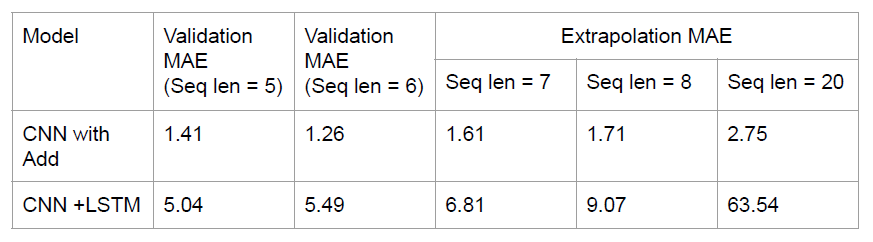

We see that the CNN with Add logic model achieved fairly good generalization error on much longer sequences. This could be because in this case the CNN model only had to recognize the digits which it is good at. 
Since the CNN+LSTM model fails to extrapolate and also a slightly higher absolute error, I check whether the LSTM model itself possesses the extrapolation capability. So, I train just the LSTM + fully connceted layer part on sequences of numbers(instead of images).

In [9]:
# This is the wrapper class to train the pytorch LSTM Model 
class LSTMNetMain(nn.Module):

  def __init__(self, input_size, hidden_size, device, num_lstm_layers=1):
    super(LSTMNetMain, self).__init__()
    self.hidden_size = hidden_size
    self.lstm_layer = nn.LSTM(input_size, hidden_size, num_lstm_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size, 1)
    self.device = device

  def forward(self, x):
    x_shape = x.shape
    x = torch.reshape(x, (x_shape[0], x_shape[1], 1))
    batch_size = x_shape[0]
    hidden_state = torch.randn(1, batch_size, self.hidden_size).cuda(device = self.device)
    cell_state = torch.randn(1, batch_size, self.hidden_size).cuda(device = self.device)
    all_out, (final_hidden_state, final_cell_state) = self.lstm_layer(x, (hidden_state, cell_state))
    final_hidden_state = final_hidden_state.view(-1, self.hidden_size) 
    out = F.relu(final_hidden_state)
    out = self.fc(out)
    out = F.relu(out)
    return out[:, 0]

In [12]:
# Code to train the pytorch LSTM model on sequences of numbers. Hidden size of LSTM = 10
BATCH_SIZE = 32
NUM_EPOCHS = 400
LEARNING_RATE = 1e-3
TRAIN_LOSS_RECORD_STEPS  = 25
SHUFFLE = True
NUM_WORKERS = 2
model_save_folder = "drive/MyDrive/CNNAdd/saved_models/"
graph_save_folder = "drive/MyDrive/CNNAdd/graphs/"
device = torch.device("cuda")
input_size = 1
hidden_size = 10

best_model_name = "LSTMBest.bin"
total_loss_graph_name = "lstm_total_loss.png"
loss_5_graph_name = "lstm_loss_5.png"
loss_6_graph_name = "lstm_loss_6.png"
mae_5_graph_name = "lstm_mae_5.png"
mae_6_graph_name = "lstm_mae_6.png"
out_file = open("drive/MyDrive/CNNAdd/terminal_output/LSTMTraining.txt", "w")
model = LSTMNetMain(input_size, hidden_size, device)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
mse_loss = nn.MSELoss(reduction="mean")
mean_absolute_error = nn.L1Loss(reduction = "mean")

print("PARAMETERS:\n LEARNING RATE: ", LEARNING_RATE, "\nBATCH SIZE: ", BATCH_SIZE, "\nEPOCHS: ",NUM_EPOCHS,"\nTRAIN LOSS RECORD STEPS",TRAIN_LOSS_RECORD_STEPS, file = out_file)

dataloader_train_5 = DataLoader(dataset_train_5, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)
dataloader_test_5 = DataLoader(dataset_test_5, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)
dataloader_train_6 = DataLoader(dataset_train_6, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)
dataloader_test_6 = DataLoader(dataset_test_6, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)

train_model(model_input = "nums")


In [ ]:
input_size = 1
hidden_size = 10
device = torch.device("cuda")
# Testing the LSTM model above
model = LSTMNetMain(input_size, hidden_size, device)
model_state_dict_path = "drive/MyDrive/CNNAdd/saved_models/LSTMBest.bin"

print("Results of extrapolation to sequences of 7:")
test_model(model, model_state_dict_path, device, dataloader_test_7, model_input = "nums")
print("Results of extrapolation to sequences of 8:")
test_model(model, model_state_dict_path, device, dataloader_test_8, model_input = "nums")
print("Results of extrapolation to sequences of 20:")
test_model(model, model_state_dict_path, device, dataloader_test_20, model_input = "nums")

Results of just LSTM+fully connected layer trained on sequences of numbers
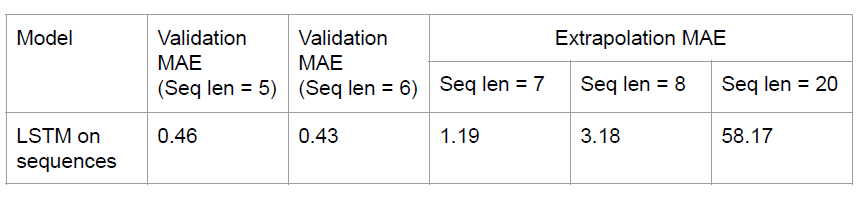

Since I found out that the LSTM model itself was not able to extrapolate to larger sequences of numbers, I attempt to create variations of the RNN model to find out if I can make the model learn the simple Add function.

Firstly, I code an LSTM model on my own and see if I am able to replicate the results I got using the pytorch LSTM

In [9]:
# Normal LSTM object code
from torch import sigmoid, tanh, relu
from torch.nn import Parameter

class MyLSTM(nn.Module):
    def __init__(self, input_size, hid_state_size):
      super(MyLSTM, self).__init__()
      self.hid_state_size = hid_state_size
      # Parameters for the forget, input, output, cell state computation in order
      self.W_f = Parameter(torch.randn(hid_state_size, input_size))
      self.W_i = Parameter(torch.randn(hid_state_size, input_size))
      self.W_o = Parameter(torch.randn(hid_state_size, input_size))
      self.W_c = Parameter(torch.randn(hid_state_size, input_size))

      self.U_f = Parameter(torch.randn(hid_state_size, hid_state_size))
      self.U_i = Parameter(torch.randn(hid_state_size, hid_state_size))
      self.U_o = Parameter(torch.randn(hid_state_size, hid_state_size))
      self.U_c = Parameter(torch.randn(hid_state_size, hid_state_size))

      self.b_f = Parameter(torch.randn(hid_state_size))
      self.b_i = Parameter(torch.randn(hid_state_size))
      self.b_o = Parameter(torch.randn(hid_state_size))
      self.b_c = Parameter(torch.randn(hid_state_size))
        
    def forward(self, x, h):
      batch_size = x.shape[0]
      sequence_length = x.shape[1]
      cell_state = h[1]
      hidden_state = h[0]
      def one_step(x_t, cell_state, hidden_state):
        f_t = sigmoid(torch.matmul(self.W_f, x_t.T).T + torch.matmul(self.U_f, hidden_state.T).T + self.b_f)
        i_t = sigmoid(torch.matmul(self.W_i, x_t.T).T + torch.matmul(self.U_i, hidden_state.T).T + self.b_i)
        o_t = sigmoid(torch.matmul(self.W_o, x_t.T).T + torch.matmul(self.U_o, hidden_state.T).T + self.b_o)
        c_t = tanh(torch.matmul(self.W_c, x_t.T).T + torch.matmul(self.U_c, hidden_state.T).T + self.b_c)
        cell_state = torch.mul(f_t, cell_state) + torch.mul(i_t, c_t)
        hidden_state = torch.mul(o_t, tanh(cell_state))
        return hidden_state, cell_state

      # Gathering the outputs for a batch and returning
      seq_outputs = []
      for i in range(sequence_length):
        hidden_state, cell_state = one_step(x[:, i, :], cell_state, hidden_state)
        seq_outputs.append(hidden_state)
      final_output = torch.stack(seq_outputs, 1)
      return final_output, (final_output[:, -1, :], cell_state)      

In [10]:
# This is the wrapper class for the  custom LSTM objects that I create
class LSTMNet(nn.Module):

  def __init__(self, lstm_object, device):
    super(LSTMNet, self).__init__()
    self.hidden_size = lstm_object.hid_state_size
    self.lstm_layer = lstm_object
    self.fc = nn.Linear(self.hidden_size, 1)
    self.device = device

  def forward(self, x):
    x_shape = x.shape
    x = torch.reshape(x, (x_shape[0], x_shape[1], 1))
    batch_size = x_shape[0]
    hidden_state = torch.zeros(batch_size, self.hidden_size).cuda(device = self.device)
    cell_state = torch.zeros(batch_size, self.hidden_size).cuda(device = self.device)
    all_out, (final_hidden_state, final_cell_state) = self.lstm_layer(x, (hidden_state, cell_state))
    final_hidden_state = final_hidden_state.view(-1, self.hidden_size) 
    out = F.relu(final_hidden_state)
    out = self.fc(out)
    out = F.relu(out)
    return out[:, 0]


In [12]:
# Code to train MyLSTM model
BATCH_SIZE = 32
NUM_EPOCHS = 400
LEARNING_RATE = 1e-3
TRAIN_LOSS_RECORD_STEPS  = 25
SHUFFLE = True
NUM_WORKERS = 2
model_save_folder = "drive/MyDrive/CNNAdd/saved_models/"
graph_save_folder = "drive/MyDrive/CNNAdd/graphs/"
device = torch.device("cuda")
input_size = 1
hidden_size = 10

best_model_name = "MyLSTMBest.bin"
total_loss_graph_name = "mylstm_total_loss.png"
loss_5_graph_name = "mylstm_loss_5.png"
loss_6_graph_name = "mylstm_loss_6.png"
mae_5_graph_name = "mylstm_mae_5.png"
mae_6_graph_name = "mylstm_mae_6.png"
out_file = open("drive/MyDrive/CNNAdd/terminal_output/MyLSTMTraining.txt", "w")
lstm_object = MyLSTM(input_size, hidden_size) 
model = LSTMNet(lstm_object, device)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
mse_loss = nn.MSELoss(reduction="mean")
mean_absolute_error = nn.L1Loss(reduction = "mean")

print("PARAMETERS:\n LEARNING RATE: ", LEARNING_RATE, "\nBATCH SIZE: ", BATCH_SIZE, "\nEPOCHS: ",NUM_EPOCHS,"\nTRAIN LOSS RECORD STEPS",TRAIN_LOSS_RECORD_STEPS, file = out_file)

dataloader_train_5 = DataLoader(dataset_train_5, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)
dataloader_test_5 = DataLoader(dataset_test_5, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)
dataloader_train_6 = DataLoader(dataset_train_6, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)
dataloader_test_6 = DataLoader(dataset_test_6, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)

train_model(model_input = "nums")

In [ ]:
# Testing the MyLSTM model above
input_size = 1
hidden_size = 10
device = torch.device("cuda")
lstm_object = MyLSTM(input_size, hidden_size) 
model = LSTMNet(lstm_object, device)
model_state_dict_path = "drive/MyDrive/CNNAdd/saved_models/MyLSTMBest.bin"

print("Results of extrapolation to sequences of 7:")
test_model(model, model_state_dict_path, device, dataloader_test_7, model_input = "nums")
print("Results of extrapolation to sequences of 8:")
test_model(model, model_state_dict_path, device, dataloader_test_8, model_input = "nums")
print("Results of extrapolation to sequences of 20:")
test_model(model, model_state_dict_path, device, dataloader_test_20, model_input = "nums")

Results of MyLSTM model

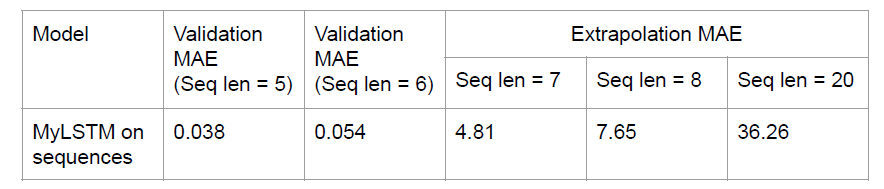

The results above are actually better compared to pytorch LSTM for in-distribution generalization. Slightly worse for extrapolation sequence lengths 7 and 8 and better for sequence length 20. These differences might be due to changes of initialization as I initialize the hidden and cell states with zero vectors.

The LSTM model actually only needs to learn a very simple Add function. I suppose that having all the complicated functions such as the tanh function and all the gates are preventing it from learning the simple Add function.

So I create a very simple RNN with the following equation at every step

_hidden_state = W.inp + U.hidden_state_

Where inp is the input at the step, W and U are weight matrices. In this the model only needs to accumulate the sum in the hidden state. The final hidden state is passed to a fully connected layer with ReLU activation function. The hidden state size I chose is 10 as above.

In [11]:
# Simple RNN model
from torch import sigmoid, tanh, relu
from torch.nn import Parameter

class VerySimpleRNN(nn.Module):
    def __init__(self, input_size, hid_state_size):
      super(VerySimpleRNN, self).__init__()
      self.hid_state_size = hid_state_size
      self.W_i = Parameter(torch.randn(hid_state_size, input_size))
      self.U_i = Parameter(torch.randn(hid_state_size, hid_state_size))

    def forward(self, x, h):
      batch_size = x.shape[0]
      sequence_length = x.shape[1]
      # Here cell state is just a place holder 
      cell_state = h[1]
      hidden_state = h[0]
      def one_step(x_t, cell_state, hidden_state):
        hidden_state = torch.matmul(self.W_i, x_t.T).T + torch.matmul(self.U_i, hidden_state.T).T
        return hidden_state, cell_state

      # Gathering the outputs for a batch and returning
      seq_outputs = []
      for i in range(sequence_length):
        hidden_state, cell_state = one_step(x[:, i, :], cell_state, hidden_state)
        seq_outputs.append(hidden_state)
      final_output = torch.stack(seq_outputs, 1)
      return final_output, (final_output[:, -1, :], cell_state)      

In [12]:
# Code to train the VerySimpleRNN model
BATCH_SIZE = 32
NUM_EPOCHS = 400
LEARNING_RATE = 1e-3
TRAIN_LOSS_RECORD_STEPS  = 25
SHUFFLE = True
NUM_WORKERS = 2
model_save_folder = "drive/MyDrive/CNNAdd/saved_models/"
graph_save_folder = "drive/MyDrive/CNNAdd/graphs/"
device = torch.device("cuda")
input_size = 1
hidden_size = 10

best_model_name = "VerySimpleRNNBest.bin"
total_loss_graph_name = "vsrnn_total_loss.png"
loss_5_graph_name = "vsrnn_loss_5.png"
loss_6_graph_name = "vsrnn_loss_6.png"
mae_5_graph_name = "vsrnn_mae_5.png"
mae_6_graph_name = "vsrnn_mae_6.png"
out_file = open("drive/MyDrive/CNNAdd/terminal_output/VSRNNTraining.txt", "w")
lstm_object = VerySimpleRNN(input_size, hidden_size) 
model = LSTMNet(lstm_object, device)

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
mse_loss = nn.MSELoss(reduction="mean")
mean_absolute_error = nn.L1Loss(reduction = "mean")

print("PARAMETERS:\n LEARNING RATE: ", LEARNING_RATE, "\nBATCH SIZE: ", BATCH_SIZE, "\nEPOCHS: ",NUM_EPOCHS,"\nTRAIN LOSS RECORD STEPS",TRAIN_LOSS_RECORD_STEPS, file = out_file)

dataloader_train_5 = DataLoader(dataset_train_5, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)
dataloader_test_5 = DataLoader(dataset_test_5, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)
dataloader_train_6 = DataLoader(dataset_train_6, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)
dataloader_test_6 = DataLoader(dataset_test_6, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)

train_model(model_input = "nums")

In [ ]:
# Testing the Very Simple RNN model above
input_size = 1
hidden_size = 10
device = torch.device("cuda")
lstm_object = VerySimpleRNN(input_size, hidden_size) 
model = LSTMNet(lstm_object, device)
model_state_dict_path = "drive/MyDrive/CNNAdd/saved_models/VerySimpleRNNBest.bin"

print("Results of extrapolation to sequences of 7:")
test_model(model, model_state_dict_path, device, dataloader_test_7, model_input = "nums")
print("Results of extrapolation to sequences of 8:")
test_model(model, model_state_dict_path, device, dataloader_test_8, model_input = "nums")
print("Results of extrapolation to sequences of 20:")
test_model(model, model_state_dict_path, device, dataloader_test_20, model_input = "nums")

Very Simple RNN results:

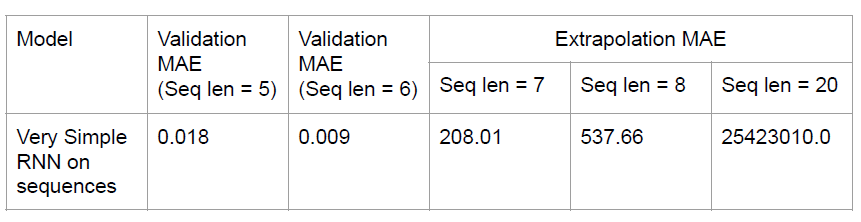

Although the in-distribution errors are the best of all, the OOD sequence errors sky-rocketed. This is an unexpected outcome which is probably happening due to repeated multiplication with a value greater than 1 in the weights causing exponential increase in value in the hidden vector with increase in sequence length.

In [16]:
# Checking the maximum weight in each of the 2 weight matrices
lstm_object = VerySimpleRNN(1, 10) 
device = torch.device("cuda")
model = LSTMNet(lstm_object, device)
model_state_dict_path = "drive/MyDrive/CNNAdd/saved_models/VerySimpleRNNBest.bin"
model.load_state_dict(torch.load(model_state_dict_path))
model.to(device)
print("Max weight in W_i:", max(model.lstm_layer.W_i.flatten()))
print("Max weight in U_i:", max(model.lstm_layer.U_i.flatten()))

Max weight in W_i: tensor(2.5347, device='cuda:0', grad_fn=<UnbindBackward0>)
Max weight in U_i: tensor(2.5630, device='cuda:0', grad_fn=<UnbindBackward0>)


After checking the weights found out that

Max weight in W_i: 2.5347

Max weight in U_i: 2.5630

These might probably be the reason for the skyrocketing of the extrapolation errors. Maybe restricting the weights to be between 0 and 1 and probably more close to the ends as in the Neural Arithmetic Logic Units paper would be helpful.


In [ ]:
"""
Here in I create a wrapper class to create models of CNN + custom RNN models, the custom RNN is passed in during initialization
of an object of this class
"""
class CNNLSTM(nn.Module):

  def __init__(self, lstm_object, device):
    super(CNNLSTM, self).__init__()
    self.conv1 = nn.Conv2d(1,32,3,1)
    self.conv2 = nn.Conv2d(32,64,3,1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 1)
    self.lstm_hidden_size = lstm_object.hid_state_size
    self.lstm_layer = lstm_object
    self.lstm_fc = nn.Linear(self.lstm_hidden_size, 1)
    self.device = device

  def forward(self, x):
    x_shape = x.shape
    x = torch.reshape(x, (x_shape[0]*x_shape[1], x_shape[2], x_shape[3], x_shape[4]))
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = torch.reshape(x, (x_shape[0], x_shape[1], 1))
    batch_size = x_shape[0]
    hidden_state = torch.zeros(batch_size, self.lstm_hidden_size).cuda(device = self.device)
    cell_state = torch.zeros(batch_size, self.lstm_hidden_size).cuda(device = self.device)
    all_out, (final_hidden_state, final_cell_state) = self.lstm_layer(x, (hidden_state, cell_state))
    final_hidden_state = final_hidden_state.view(-1, self.lstm_hidden_size) 
    out = F.relu(final_hidden_state)
    out = self.lstm_fc(out)
    out = F.relu(out)
    return out[:, 0]


In [ ]:
# Code to train CNN+pytorch LSTM/Custom LSTM Models
BATCH_SIZE = 32
NUM_EPOCHS = 300
LEARNING_RATE = 1e-3
TRAIN_LOSS_RECORD_STEPS  = 25
SHUFFLE = True
NUM_WORKERS = 2
device = torch.device("cuda")
model_save_folder = "drive/MyDrive/CNNAdd/saved_models/"
graph_save_folder = "drive/MyDrive/CNNAdd/graphs/"
input_size = 1
hidden_size =  10

# best_model_name = "CNNLSTMBest2.bin"
# total_loss_graph_name = "cnnlstm_total_loss2.png"
# loss_5_graph_name = "cnnlstm_loss_5_2.png"
# loss_6_graph_name = "cnnlstm_loss_6_2.png"
# mae_5_graph_name = "cnnlstm_mae_5_2.png"
# mae_6_graph_name = "cnnlstm_mae_6_2.png"
# out_file = open("drive/MyDrive/CNNAdd/terminal_output/CNNLSTMTraining2.txt", "w")
# lstm_object = MyLSTM(input_size, hidden_size)
# model = CNNLSTM(lstm_object, device)

model.to(device= device)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
mse_loss = nn.MSELoss(reduction="mean")
mean_absolute_error = nn.L1Loss(reduction = "mean")

print("PARAMETERS:\n LEARNING RATE: ", LEARNING_RATE, "\nBATCH SIZE: ", BATCH_SIZE, "\nEPOCHS: ",NUM_EPOCHS,"\nTRAIN LOSS RECORD STEPS",TRAIN_LOSS_RECORD_STEPS, file = out_file)

dataloader_train_5 = DataLoader(dataset_train_5, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)
dataloader_test_5 = DataLoader(dataset_test_5, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)
dataloader_train_6 = DataLoader(dataset_train_6, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)
dataloader_test_6 = DataLoader(dataset_test_6, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)

train_model()

This shows that learning to generalize on in-distribution data and learning a function that also generalizes on OOD data are two very different things. Also it seems that composition of neural networks doesn't work in a straight-forward manner. This can be seen by checking the results of CNN with Logic model results and LSTM results and comparing it with CNN + LSTM model results. Although the individual models could generalize fairly well on in-distribution data, the combined model couldn't perform as well.

<h2>More experiments and results coming soon...<h2>